# This notebook shows how to built a recurrent neural network for time series. The variable is the price of bitcoin. 

Note: the model is not optimized, it is a matter of fitting many models with different parameters.

In [1]:
import pandas as pd
import requests
import json
import numpy as np
import matplotlib.pyplot as plt

from keras import models
from keras import layers
from keras import optimizers
from keras import metrics
from keras.layers import LSTM
from keras.models import Sequential
from keras.callbacks import EarlyStopping
from keras.optimizers import RMSprop

from sklearn.metrics import mean_squared_error

## 1. Data downloading

The price of bitcoin is downloaded from glassnode website using API. 
- asset: bitcoin closing price
- start date: 01/09/2013
- end date: the day the script is run, to set a specific end date a user needs to give the "u" parameter
- period: 24H

Note: The author's API key can be found below. API key is necessary. In order to get it a glassnode account is needed.
More details can be found on https://docs.glassnode.com/basic-api/api

In [2]:
API_KEY = "1sFwvRMssNV1aw7gySviqqpMrdb" # API key for access

url_price = "https://api.glassnode.com/v1/metrics/market/price_usd_close" # url with bitcoin prices

#parameters for data downloading
params_price = {
    "a": "BTC",
    "s": 1377993600, #starting date in UNIX time: 01/09/2013
    #"u": ending date in UNIX time
    "i": "24h", #period
    "timestamp_format": "humanized", 
    "api_key": API_KEY
}

res = requests.get(url_price, params=params_price)

#converting data to pandas dataframe
data = pd.read_json(res.text, convert_dates=['t'])

In [3]:
data.head()

,t,v
0,2013-09-01 00:00:00+00:00,130.668000
1,2013-09-02 00:00:00+00:00,130.070720
2,2013-09-03 00:00:00+00:00,129.179367
3,2013-09-04 00:00:00+00:00,122.179970
4,2013-09-05 00:00:00+00:00,122.619851


In [4]:
data["t"] = pd.to_datetime(data["t"].dt.strftime('%Y-%m-%d')) # changing date format
data.rename(columns={"v": "price [USD]", "t": "date"}, inplace=True) # renaming the columns
data.set_index('date', drop=True, inplace=True) # reseting the index

In [5]:
data.head()

,price [USD]
date,
2013-09-01,130.668000
2013-09-02,130.070720
2013-09-03,129.179367
2013-09-04,122.179970
2013-09-05,122.619851


In [6]:
data.shape

(2816, 1)

Visualization of the variable

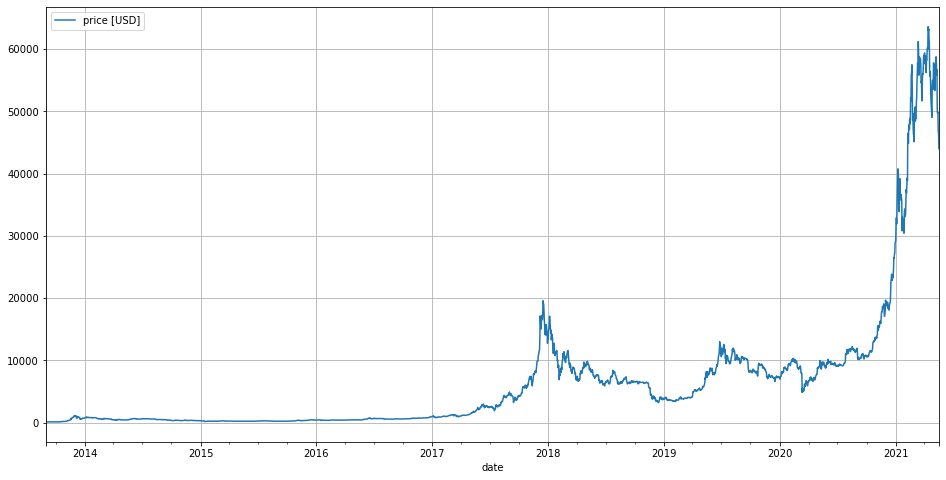

In [7]:
data.plot(figsize=(16,8))
plt.grid()

## 2. Building neural network

The process proceeded in the following way:
1. Spliting the data into training, validation and test set
2. Normalizing the data basing on the training set
3. Adjusting the data to Recurrent Neural Network (RNN) - reshaping
4. Training the model (with validation set)
5. Evaluating the model

__2.1 Splitng the data into training, validation and test set__

In [8]:
n = data.shape[0]

# size of the training set
training_size = int(0.7 * n)
# train data
train_data = data[:training_size].values.astype('float32')

# size of the validation set
val_size = int(0.1 * n)
# validation data
val_data = data[training_size:(training_size + val_size)].values.astype('float32')

# test data (its size results from the previoues sizes)
test_data = data[(training_size + val_size):].values.astype('float32')

__2.2 Normalizing the data__

In [9]:
data2 = data.copy()

# normalizing the data using the training set 
# (the assumption is that we have only training data - the rest is predicted)
min_ = train_data.min(axis = 0)
max_ = train_data.max(axis = 0)

train_data = (train_data - min_) / (max_ - min_)
val_data = (val_data - min_) / (max_ - min_)
test_data = (test_data - min_) / (max_ - min_)

__2.3 Adjusting the data to recurrent neural network__

The schema below shows how the data are prepared:
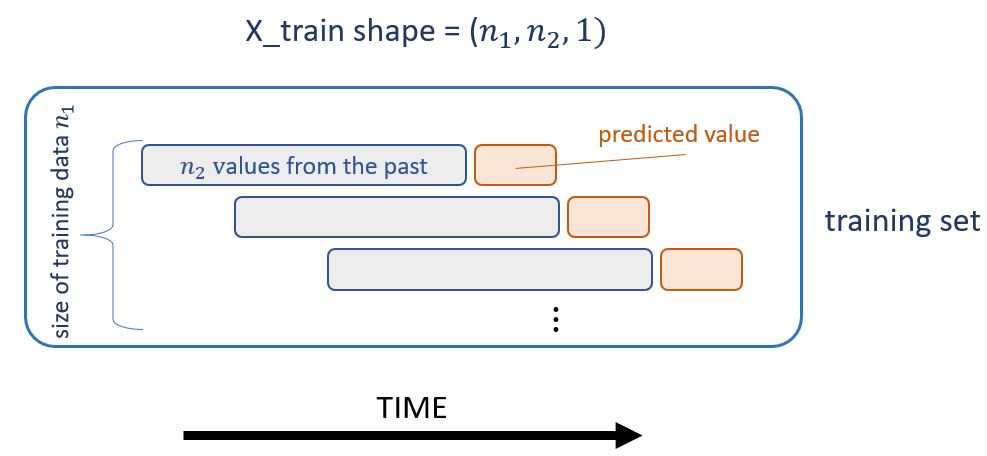

In [10]:
# number of previous days network will use for predicting the price on next days
number_of_days = 60

# adjusting data
X_train = []
y_train = []

for i in range(number_of_days, len(train_data)):
    # training input data - numer of days which are used for predicting the price
    X_train.append(train_data[(i - number_of_days):i])
    # training labels - the true price
    y_train.append(train_data[i]) 

X_train, y_train = np.array(X_train), np.array(y_train)

# reshaping the data into three dimensions
X_train = X_train.reshape(training_size - number_of_days, number_of_days, 1) 

# the process of adjusting validation and test data is the same
X_val = []
y_val = []

for i in range(number_of_days, len(val_data)):
    X_val.append(val_data[(i - number_of_days):i])
    y_val.append(val_data[i])

X_val, y_val = np.array(X_val), np.array(y_val)    
X_val = X_val.reshape(val_size - number_of_days, number_of_days, 1) 

X_test = []
y_test = []

for i in range(number_of_days, len(test_data)):
    X_test.append(test_data[i-number_of_days:i])
    y_test.append(test_data[i])

X_test = np.array(X_test)
y_test = np.array(y_test)

In [11]:
X_train.shape, X_val.shape, X_test.shape

((1911, 60, 1), (221, 60, 1), (504, 60, 1))

In [12]:
y_train.shape, y_val.shape, y_test.shape

((1911, 1), (221, 1), (504, 1))

__2.4 Training the model__

In [14]:
# building the neural network model

# Stop training when a monitored metric has stopped improving.
early_stopping = EarlyStopping(patience=5, monitor='val_loss', restore_best_weights=True)

model = Sequential()
model.add(layers.LSTM(128, input_shape = (X_train.shape[1], X_train.shape[2]), return_sequences=False, activation='relu'))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(1))

In [15]:
# number of epochs
# an epoch means training the neural network with all the training data for one cycle
num_epochs = 80

# number of samples that will be propagated through the network
batch_size = 64

# used metric root mean squared error
model.compile(optimizer=RMSprop(), loss='mse', metrics=[metrics.RootMeanSquaredError()])
history = model.fit(X_train, y_train, 
                    batch_size=batch_size, 
                    epochs=num_epochs, 
                    validation_data=(X_val, y_val),
                    callbacks=[early_stopping])

Epoch 1/80
30/30 [==============================] - 2s 67ms/step - loss: 0.0805 - root_mean_squared_error: 0.2837 - val_loss: 0.0215 - val_root_mean_squared_error: 0.1467
Epoch 2/80
30/30 [==============================] - 2s 57ms/step - loss: 0.0023 - root_mean_squared_error: 0.0475 - val_loss: 0.0056 - val_root_mean_squared_error: 0.0748
Epoch 3/80
30/30 [==============================] - 2s 57ms/step - loss: 0.0014 - root_mean_squared_error: 0.0372 - val_loss: 0.0016 - val_root_mean_squared_error: 0.0397
Epoch 4/80
30/30 [==============================] - 2s 57ms/step - loss: 0.0011 - root_mean_squared_error: 0.0337 - val_loss: 0.0015 - val_root_mean_squared_error: 0.0388
Epoch 5/80
30/30 [==============================] - 2s 57ms/step - loss: 8.9527e-04 - root_mean_squared_error: 0.0299 - val_loss: 0.0012 - val_root_mean_squared_error: 0.0351
Epoch 6/80
30/30 [==============================] - 2s 57ms/step - loss: 0.0010 - root_mean_squared_error: 0.0322 - val_loss: 0.0034 - val_ro

__2.5 Model evaluation__

2.5.1 Training performance - checking if overfitting occured (whether validation and training lines are close together)

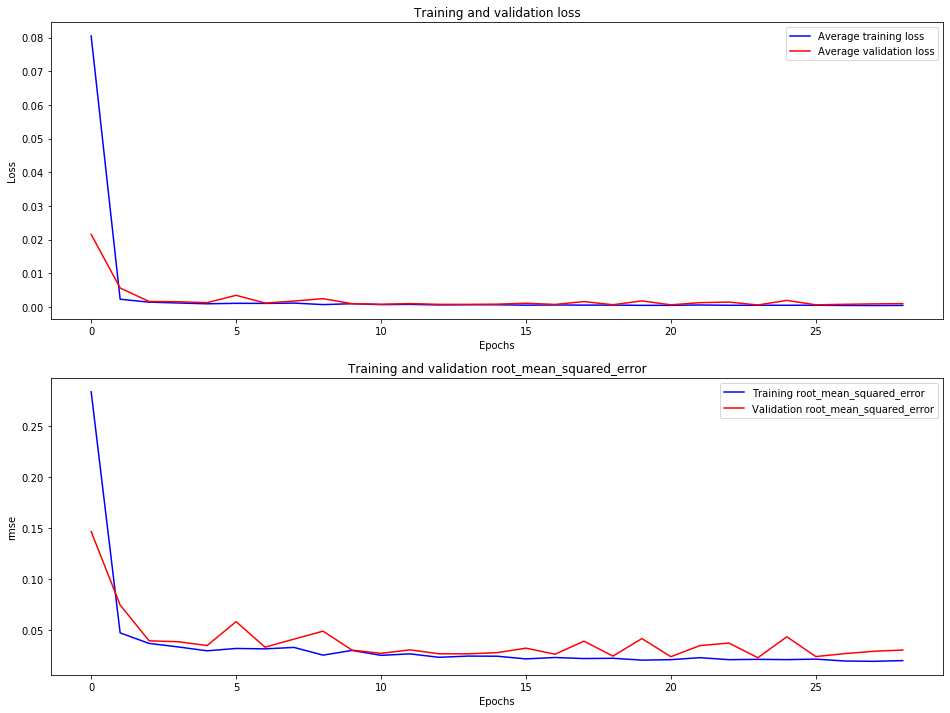

In [17]:
training_loss = history.history['loss']
training_rmse = history.history['root_mean_squared_error']
val_loss = history.history['val_loss']
val_rmse = history.history['val_root_mean_squared_error']

figure, ax = plt.subplots(2, figsize=(16, 12))
ax[0].plot(history.epoch, training_loss, 'b', label='Average training loss')
ax[0].plot(history.epoch, val_loss, 'r', label='Average validation loss')
ax[0].set_title('Training and validation loss')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].legend()

ax[1].plot(history.epoch, training_rmse, 'b', label='Training root_mean_squared_error')
ax[1].plot(history.epoch, val_rmse, 'r', label='Validation root_mean_squared_error')
ax[1].set_title('Training and validation root_mean_squared_error')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('rmse')
ax[1].legend()

2.5.2 How the model predicts

In [19]:
# predicted values
y_pred = model.predict(X_test)

In [21]:
#rescaling the test and predicted values
y_pred_rescaled = y_pred * (max_ - min_) + min_
y_test_rescaled = y_test * (max_ - min_) + min_

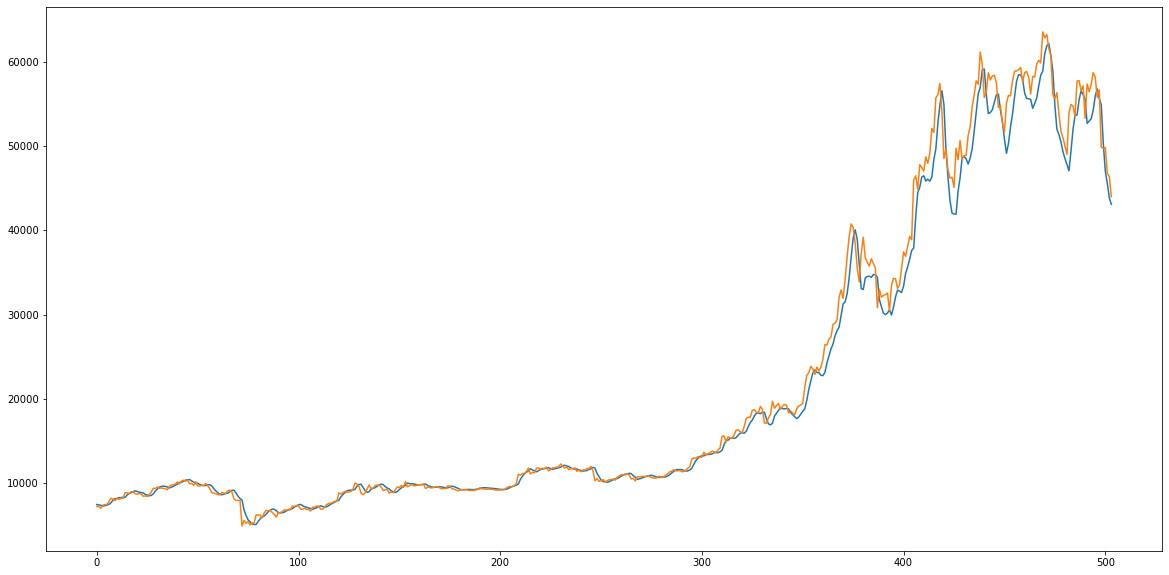

In [51]:
fig, ax = plt.subplots(figsize=(20, 10))

plt.plot(np.arange(len(y_test_rescaled)), y_pred_rescaled)
plt.plot(np.arange(len(y_test_rescaled)), y_test_rescaled)

2.5.3 Root mean squared error

In [54]:
#Root mean squared error of predicted and true values
mean_squared_error(y_test_rescaled, y_pred_rescaled, squared=False)

1721.021